In [67]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from model import loss
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s",
                    datefmt=date_strftime_format)


In [97]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)
import torchgeometry as tgm
importlib.reload(tgm)

<module 'torchgeometry' from '/home/btrippe/.local/lib/python3.9/site-packages/torchgeometry/__init__.py'>

In [76]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0

# Translations

In [62]:
min_b = 0.1
max_b = 20
num_t = 100
dt = 1 / num_t
r3_diff = r3_diffuser.R3Diffuser(min_b = min_b, max_b = max_b)

In [42]:
# Simulating diffusion
num_t = 100
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]

In [43]:
# Reverse diffusion
def reverse_diffusion_sim(score_fcn, diffuser, forward_t, N):
    """simulate from reverse process
    
    Args:
        reference: distribution, calls sample one instance
        foward_t: list of time steps in discretization between 0 and 1
    """
    reverse_samples = {}
    curr_step = diffuser.sample_ref(n_samples=N)
    for i, t in reversed(list(enumerate(forward_t))):
        dt = forward_t[i]- forward_t[i-1] if i !=0 else forward_t[i+1] - forward_t[i]
        score_t = score_fcn(curr_step, t)
        curr_step = diffuser.reverse(curr_step, score_t=score_t, t=t, dt=dt)
        reverse_samples[i] = copy.deepcopy(curr_step)
    return reverse_samples
        
def compare_forward_and_rev(reverse_samples,marginal_samples, x_lim= 5, num_bins =20,
                            t_idcs = [2, 10, 20, 50, 98, 99]):
    """compare_forward_and_rev makes plots for each time index provided comparing forward and reverse marginals
    """
    bins = np.linspace(-x_lim, x_lim, num_bins)
    f, axes = plt.subplots(len(t_idcs), 3, figsize=[20, 4*len(t_idcs)])
    for i, t_idx in enumerate(t_idcs):
        for j in range(3):
            reverse_i = np.stack(reverse_samples[t_idx])[:, j]
            axes[i, j].hist(reverse_i, density=True, label='reverse', histtype='step', bins=bins)

            forward_i = np.stack(marginal_samples[t_idx])[:, j]
            axes[i, j].hist(forward_i, density=True, label='forward', histtype='step', bins=bins)

            axes[i, j].set_xlim(-x_lim, x_lim)
            axes[i, j].set_title(f't={t_idx},coord={j}')
            axes[i, j].legend(loc="upper left")

In [44]:
# Forward diffusion
# x_1 = np.random.normal(size=(1, 3))
N = 500
x_0 = np.ones((1, 3))
marginal_samples = {t_idx:torch.tensor(
    [r3_diff.forward_marginal(x_0, t)[0][0] for _ in range(N)]
) for t_idx, t in enumerate(forward_t)}

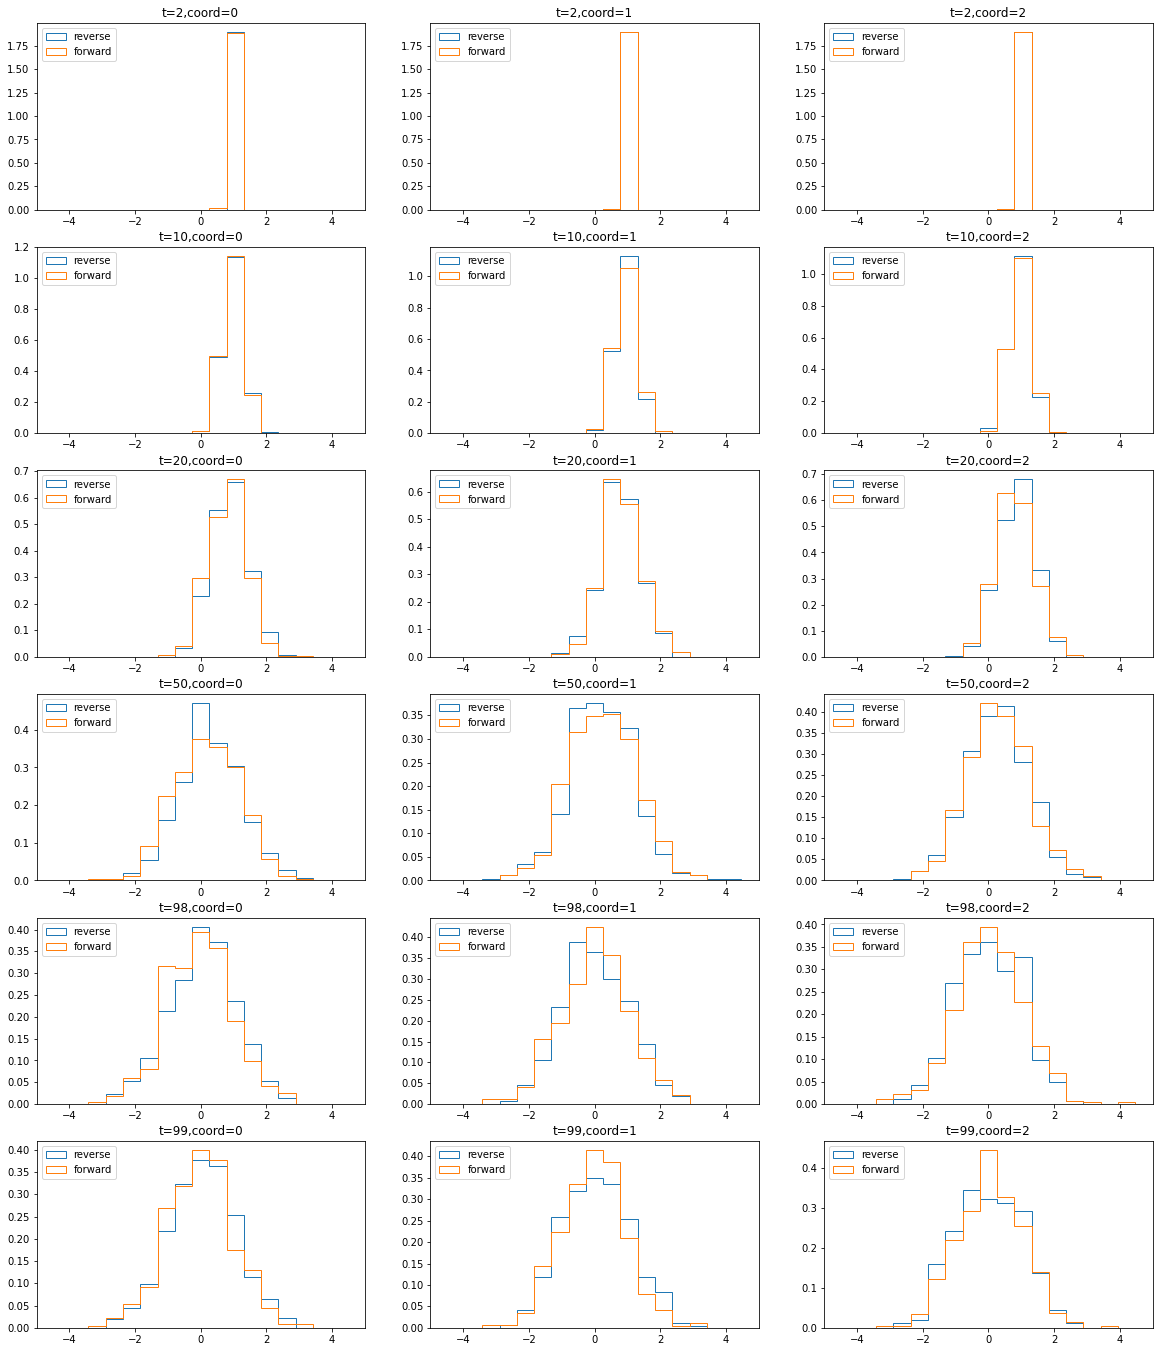

In [45]:
reference = lambda: np.random.normal(size=(1, 3))
score_fcn = lambda x_t, t: r3_diff.score(x_t, x_0, t)
reverse_samples = reverse_diffusion_sim(score_fcn, r3_diff, forward_t, N)
compare_forward_and_rev(reverse_samples, marginal_samples)

In [46]:
class r3_normal_mixture:
    def __init__(self, K=3):
        self.K = K
        self.mu = torch.normal(mean=0, std=1, size=[K, 3])
        self.std = 0.1
        
    def sample(self, N):
        """sample from t=0 distribution"""
        idcs = torch.multinomial(torch.ones([self.K])/self.K, num_samples=N, replacement=True)
        mu = self.mu[idcs]
        return mu + torch.normal(mean=0, std=self.std, size=[N, 3])
    
    
    def density(self, x):
        """up to proportionality
        
        Args:
            x.shape = [N, 3]
        """
        ps = [torch.exp(-0.5*((x-self.mu[k, None])**2).sum(axis=-1)/(self.std**2)) for k in range(self.K)]
        ps = torch.stack(ps).sum(axis=0)
        return ps
    
    def marginal_sample(self, N, t, diffuser):
        idcs = torch.multinomial(torch.ones([self.K])/self.K, num_samples=N, replacement=True)
        mu = self.mu[idcs]
        t = torch.tensor(t)
        bar_alpha = diffuser.bar_alpha(t)
        mean = torch.sqrt(bar_alpha)*mu
        var = bar_alpha*self.std**2 + (1-bar_alpha)
        return torch.normal(mean, std=torch.sqrt(var))
        

    def density_t(self, x, t, diffuser):
        """up to proportionality"""
        ps = []
        for k in range(self.K):
            t = torch.tensor(t)
            bar_alpha = diffuser.bar_alpha(t)
            mean = torch.sqrt(bar_alpha)*self.mu[k]
            var = bar_alpha*self.std**2 + (1-bar_alpha)
            p_k = torch.exp(-0.5*(
                (x-mean[None])**2
            ).sum(axis=-1)/var)            
            ps.append(p_k)
        ps = torch.stack(ps).sum(axis=0)
        return ps
    
    def score(self, x, t, diffuser):
        x = torch.tensor(x, requires_grad=True)
        log_p = torch.log(self.density_t(x, t, diffuser)).sum()
        return torch.autograd.grad(log_p, x)[0].numpy()

In [47]:
k = 3
N = 10000
mix = r3_normal_mixture(k)
score_fcn = lambda x_t, t: mix.score(x_t, t, r3_diff)

In [48]:
# sample from both forward and reverse
reverse_samples = reverse_diffusion_sim(score_fcn, r3_diff, forward_t, N)
marginal_samples = {t_idx:mix.marginal_sample(N, t, r3_diff) for t_idx, t in enumerate(forward_t)}

/scratch/btrippe/52480481/ipykernel_2798896/472042458.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


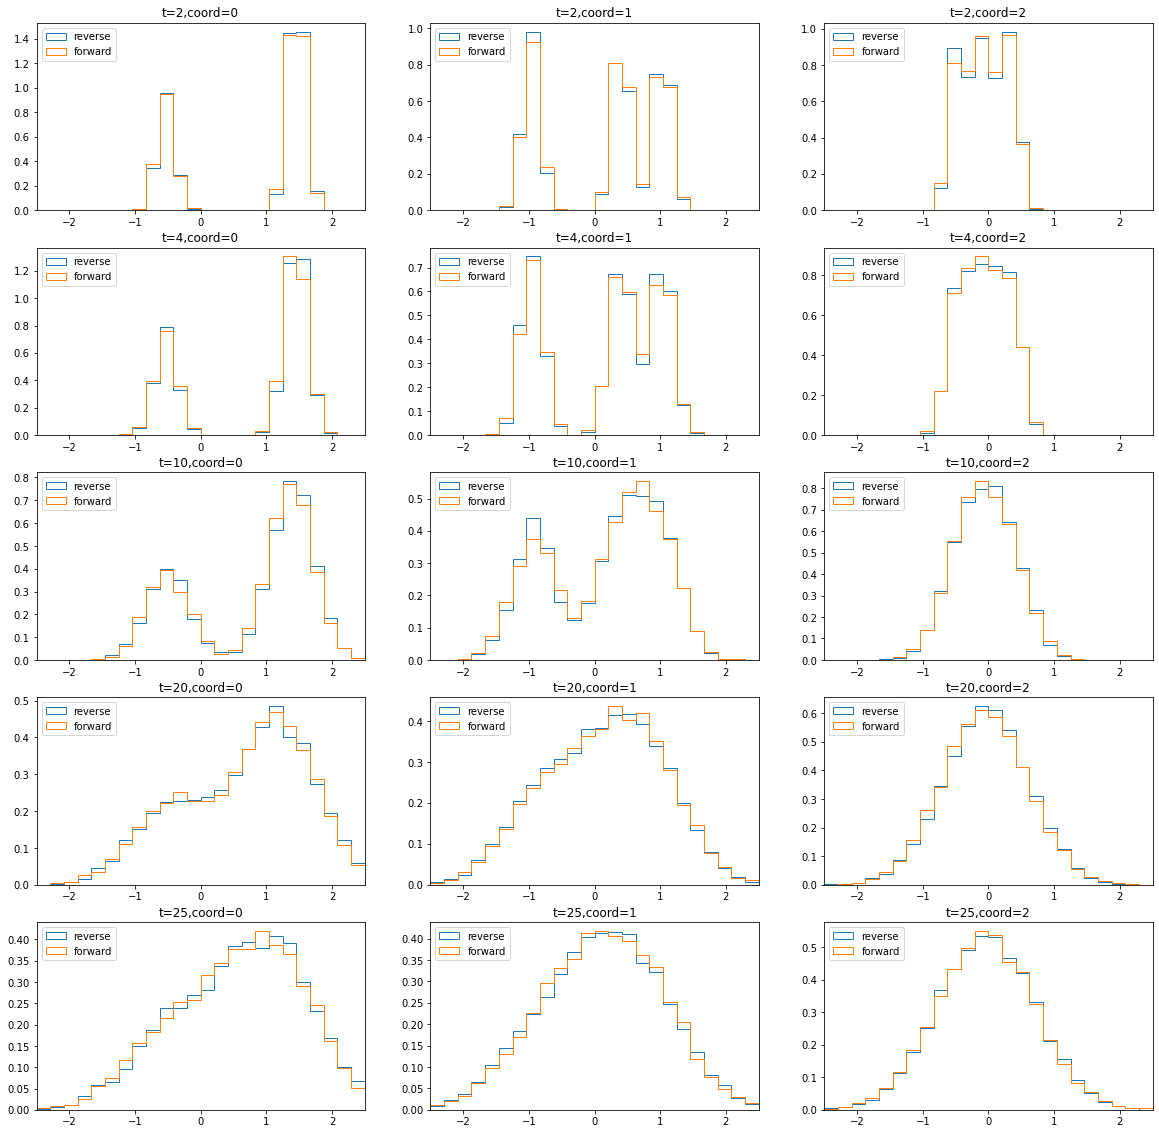

In [49]:
# plot comparison
compare_forward_and_rev(reverse_samples, marginal_samples, t_idcs=[2,4, 10, 20, 25], num_bins=25, x_lim=2.5)

# Rotations

In [63]:
diff_conf = conf.diffuser
num_sigma = 1000
num_omega = 1000
min_sigma = 0.05
max_sigma = 1.5

In [64]:
torch.any

<function _VariableFunctionsClass.any>

In [106]:
rot_diff = so3_diffuser.SO3Diffuser(
    cache_dir=diff_conf.igso3_cache_dir,
    num_sigma=num_sigma,
    num_omega=num_omega,
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    schedule='linear'
)

INFO: Computing IGSO3.


In [108]:
# Forward diffusion
rot_0 = np.zeros([N,3])
marginal_samples = {t_idx:torch.tensor(
    rot_diff.forward_marginal(rot_0, t)[0]
) for t_idx, t in enumerate(forward_t)}

score_fcn = lambda x_t, t: rot_diff.score(x_t, t)
reverse_samples = reverse_diffusion_sim(score_fcn, rot_diff, forward_t, N)

using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g


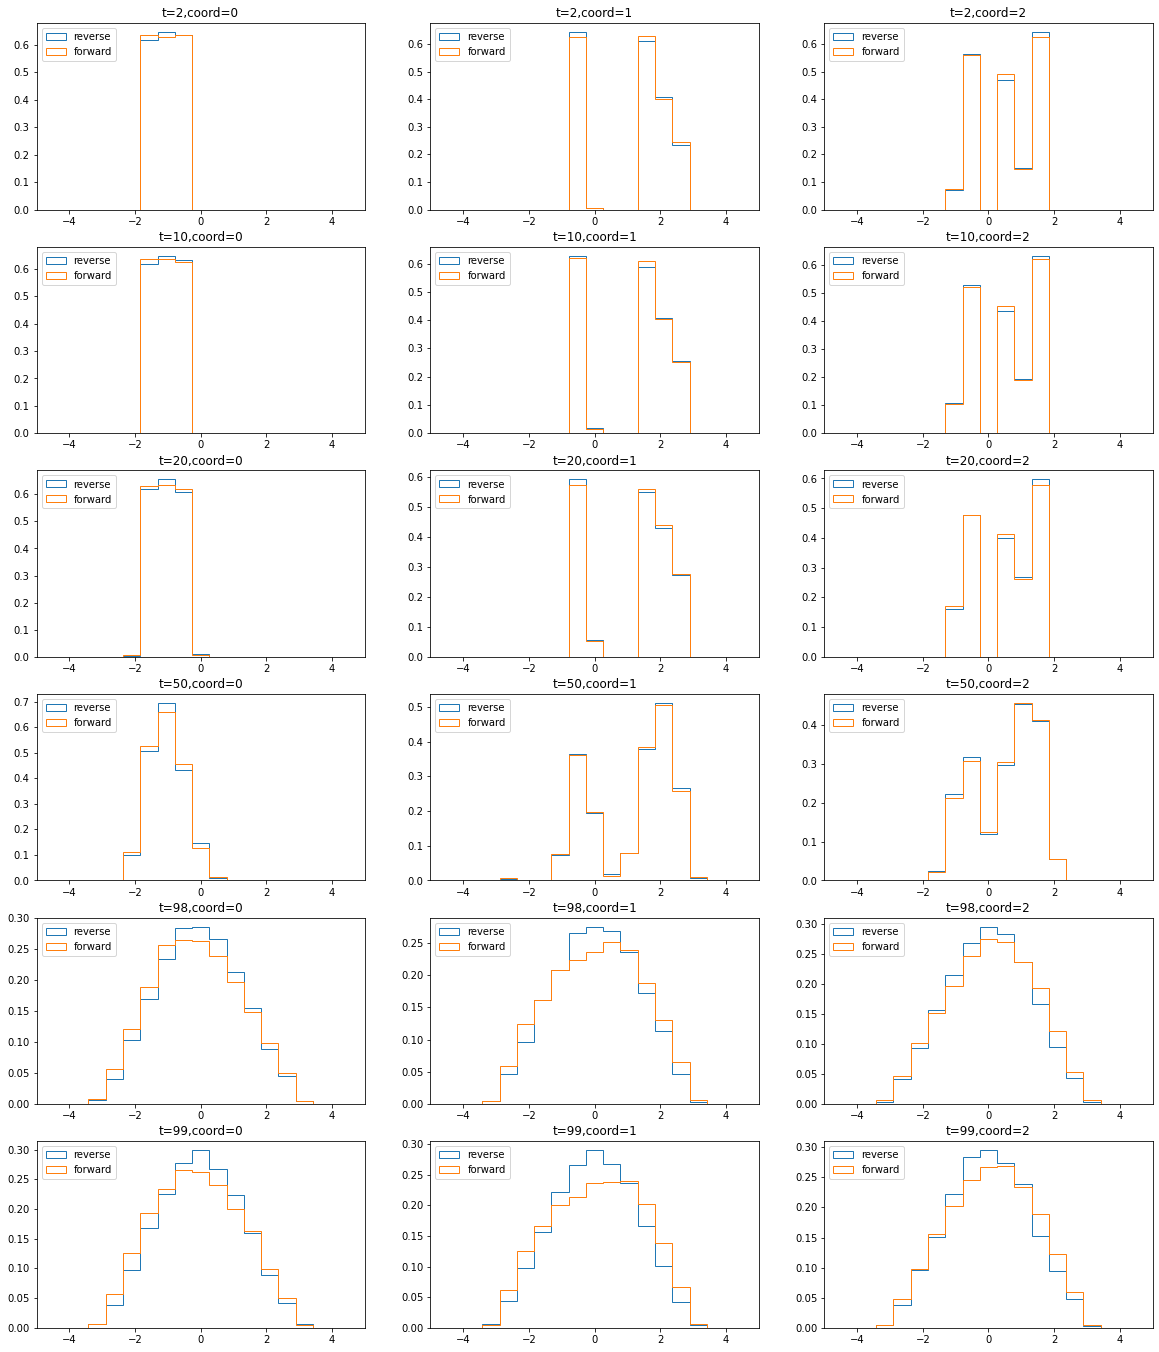

In [107]:
compare_forward_and_rev(reverse_samples, marginal_samples)

## Rotation mixture

In [101]:
class IGSO3Mix:
    """IGSO3Mix allows sampling and score computation for IGSO(3)"""
    
    def __init__(self, K, rot_diff):
        self.K = K
        self.centers = torch.tensor(rot_diff.sample_ref(n_samples=K))

    def sample(self, t, N, rot_diff):
        
        # pick centers randomly
        idcs = torch.multinomial(torch.ones([self.K])/self.K, num_samples=N, replacement=True)
        mu = self.centers[idcs]
        
        # apply random perturbation from igso3 to centers
        perturb = torch.tensor(rot_diff.sample(t, N))
        return du.compose_rotvect_pytorch(mu, perturb)

    def log_density_wrt_unif(self, rot_vec: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        """density_wrt_unif computes the (approximate) density of a rotation vector w.r.t. 
        the uniform distribution on SO(3).

        May be off by a constant factor (which wouldn't matter for score computation)
        
        Args:
          rot_vec: rotation vecotr of shape [N, 3]
          sigma: sqrt of "variance" parameter [1, D] (to match up with time in Brownian motion)
          
        Returns:
            density funtion evaluated for each angle and epsilon of shape [T, D]
                rows correspond to angle and columns to variances
        """
        # cut var_d by factor of two so that parameterization agrees with Brownian motion
        var_d = (1/2)*sigma.double()**2
        t_d = rot_vec.norm(dim=-1).double()
        log_vals = np.log(np.pi)/2 -(3/2)* torch.log(var_d) + (var_d / 4) - ((t_d / 2) ** 2) / var_d
        
        # Modified here to push some exponential factors together to reduce NaNs
        next_term = torch.log(t_d - 
            (t_d - 2 * np.pi) * torch.exp((np.pi / var_d)*(t_d - np.pi)) + (
                            t_d + 2 * np.pi) * torch.exp(-(np.pi / var_d)*(t_d + np.pi))
                  )  - torch.log(2 * torch.sin(t_d / 2))
        log_vals += next_term
        
        # skip 1-cos/pi term because w.r.t. uniform dist on SO(3)
        if torch.sum(log_vals.isinf()) + torch.sum(log_vals.isnan()):
            print(f"# inf = {log_vals.isinf().sum()}/{torch.prod(torch.tensor(log_vals.shape))}, "+
                  f" # nan = {log_vals.isnan().sum()}/{torch.prod(torch.tensor(log_vals.shape))}")
            log_vals[log_vals.isinf() + log_vals.isnan()] = 0.0

        return log_vals

    def log_density_t(self, rel_rots, t, diffuser):
        """log_density_t computes the density at time t

        Args:
            rel_rots: rotation vector describing rotation relative to each of the cluster centers
                 of shape [K, N, 3]
            t: scalar time within 0, 1
        """
        # compute "time" of the Brownian motion at t
        sigma_t = torch.tensor(diffuser.sigma(t))        
        log_ps = torch.stack([self.log_density_wrt_unif(r, sigma_t) for r in rel_rots]).logsumexp(axis=0)
        return log_ps.float()
    
    def score(self, x, t, diffuser):
        """score computes the score on SO(3) of the mixture density
        """
        x = torch.tensor(x)
        x = torch.stack(
            [du.compose_rotvect_pytorch(-c[None], x) for c in self.centers]
        ).requires_grad_(True)

        p = self.log_density_t(x, t, diffuser).exp()
        grads = torch.autograd.grad(p.sum(), x)[0].sum(axis=0)
        grads /= p.detach()[:, None] # divide by probabilty (since d/dx log f(x) = (d/dx f(x) )/ f(x))
        return grads.numpy()

In [102]:
a = torch.tensor(5.)
type(a) == torch.Tensor

True

In [103]:
mix = IGSO3Mix(k, rot_diff)

In [104]:
marginal_samples = {t_idx:mix.sample(t, N, rot_diff) for t_idx, t in enumerate(forward_t)}

In [105]:
score_fcn = lambda x_t, t: mix.score(x_t, t, rot_diff)
reverse_samples = reverse_diffusion_sim(score_fcn, rot_diff, forward_t, N)

/scratch/btrippe/52480481/ipykernel_2798896/664733667.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma_t = torch.tensor(diffuser.sigma(t))


using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g
using g


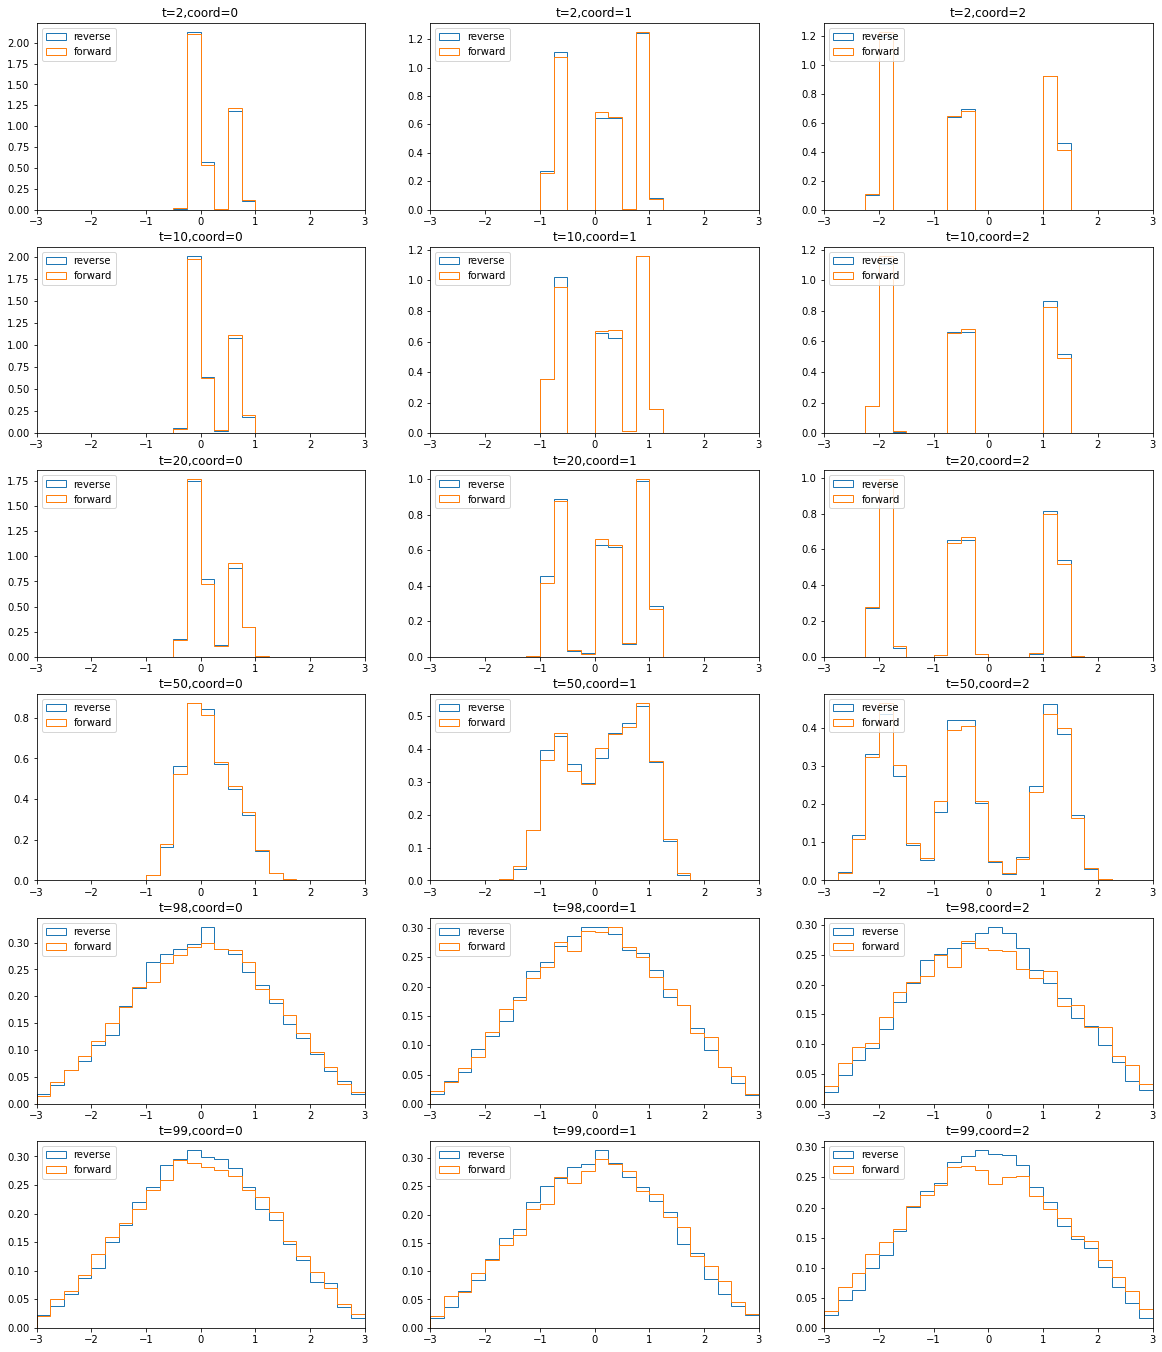

In [25]:
compare_forward_and_rev(reverse_samples, marginal_samples, x_lim=3, num_bins=25)